In [106]:
import pickle
import time
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.sparse import csc_matrix
import joblib
import os
import linecache

import karateclub
from karateclub import DeepWalk
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV

In [2]:
edges_cc = pd.read_csv("data/edges_cc.csv")

In [120]:
KG = nx.read_gpickle("training_KG_concepts.gpickle")
G = nx.convert_node_labels_to_integers(KG)
A = nx.adjacency_matrix(G).todense()

In [143]:
all_vertices = list(KG.nodes)

embeddings

In [ ]:
model = DeepWalk()
model.fit(G)

In [81]:
# np.save("training_graph_embeddings.npy", model.get_embedding())
embeddings = np.load("training_graph_embeddings.npy")

In [107]:
def retrieve_spl(node1, node2):
    """
    Retrieves all shortest path lengths from a particular node.
    """
    node = node1
    file_ranges = [
        [int(i) for i in s.split("_")[:2]] \
        for s \
        in os.listdir("shortest_paths")
    ]
    for r in file_ranges:
        if r[0]<=node<=r[1]:
            file = "shortest_paths/%d_%d_lengths.txt"%(r[0], r[1])
            break
    line = node - r[0] + 1
    lengths = linecache.getline(
        file,
        line)
    return [
        int(i) \
        if i != "nan" \
        else np.nan
        for i \
        in lengths[1:-2].split(", ")
    ][node2]

In for a fair head-to-head comparison, we can't use so many edges

In [272]:
n = len(G)
embeddings = model.get_embedding()

In [301]:
all_edges = G.edges
positive_samples = int(len(all_edges)*0.1) #34668
X_train_indices = random.sample(all_edges, positive_samples)
while len(X_train_indices) < positive_samples*2:
    edge = (random.randint(0, n-1), random.randint(0, n-1))
    if edge not in all_edges:
        X_train_indices.append(edge)

In [304]:
y_train = [1]*positive_samples + [0]*positive_samples

In [305]:
c = list(zip(X_train_indices, y_train))
random.shuffle(c)
X_train_indices, y_train = zip(*c)

In [306]:
X_train_embeddings = [
    np.concatenate([embeddings[tup[0]], embeddings[tup[1]]]) \
    for tup in X_train_indices
]

In [315]:
np.save("X_train_indices_69336.npy", X_train_indices)
np.save("X_train_embeddings_69336.npy", X_train_embeddings)
np.save("y_train_69336.npy", y_train)

In [111]:
X_train_embeddings = np.load("X_train_embeddings_69336.npy").tolist()
y_train = np.load("y_train_69336.npy").tolist()
clf_embeddings_69336_mlp = MLPClassifier((64, 12))
clf_embeddings_69336_mlp.fit(X_train_embeddings, y_train)
joblib.dump(clf_embeddings_69336_mlp, "deepwalk_mlp_69336.sav")

['deepwalk_mlp_69336.sav']

In [ ]:
roc_auc_score(y_test, clf_embeddings_69336_mlp.predict_proba(X_test_embeddings)[:, 1])

In [ ]:
average_precision_score(y_test, clf_embeddings_69336_mlp.predict_proba(X_test_embeddings)[:, 1])

Get Geodesic data for X_train_indices. Using 90-percentile effective diameter where disconnected https://raw.githubusercontent.com/kunegis/konect-handbook/master/konect-handbook.pdf (page 30) - the number of edges
needed on average to reach 90% of all other nodes

In [118]:
X_train_indices = np.load("X_train_indices_69336.npy").tolist()
y_train = np.load("y_train_69336.npy").tolist()

In [122]:
H = G.copy()

In [123]:
betweenness_dict_10000 = np.load("betweenness_dict_10000.npy", allow_pickle=True).item()

In [124]:
edges_to_remove = [
    X_train_indices[i] \
    for i in range(len(X_train_indices)) \
    if y_train[i] == 1
]
H.remove_edges_from(edges_to_remove)

In [ ]:
X_train_geodesic = []
for edge in X_train_indices:
    if edge in edges_to_remove:
        try:
            path_len = nx.astar_path_length(H, edge[0], edge[1])
        except:
            path_len = 5 #90-percentile effective diameter
    else:
        path_len = retrieve_spl(edge[0], edge[1])
        
    tup = [
        betweenness_dict_10000[list(KG.nodes)[edge[0]]],
        betweenness_dict_10000[list(KG.nodes)[edge[1]]],
        path_len
    ]
    X_train_geodesic.append(tup)

In [14]:
clf_geodesic_69336 = GradientBoostingClassifier(
    n_estimators=100,
    random_state=0
)
clf_geodesic_69336.fit(X_train_geodesic, y_train)
joblib.dump(clf_geodesic_69336, "geodesic_gbc_69336.sav")
# joblib.load("geodesic_gbc_69336.sav")

['geodesic_gbc_69336.sav']

Get test data

In [46]:
all_nodes = list(KG.nodes)

In [36]:
edges_cc = pd.read_csv("data/edges_cc.csv")
all_edges = [
    (edges_cc.src[i], edges_cc.dst[i]) \
    for i \
    in range(len(edges_cc))
]
training_edges = list(KG.edges())
training_edges += [i[::-1] for i in training_edges]
validation_edges = list(set(all_edges)-set(training_edges))
validation_edges = [
    pair for pair \
    in validation_edges \
    if np.nan not in pair \
    and pair[0] in all_nodes \
    and pair[1] in all_nodes
]

In [56]:
X_test_indices = [(all_nodes.index(pair[0]), all_nodes.index(pair[1])) for pair in validation_edges]

In [73]:
n = len(X_test_indices)
#obtain negative examples
while len(X_test_indices)< 2*n:
    edge = (random.randint(0, len(all_nodes)-1), random.randint(0, len(all_nodes)-1))
    if (
        edge not in X_test_indices \
        and edge[::-1] not in X_test_indices \
        and list(edge) not in X_train_indices \
        and list(edge[::-1]) not in X_train_indices
    ):
        X_test_indices.append(edge)

In [76]:
y_test = [1]*n + [0]*n

In [113]:
np.save("X_test_indices.npy", X_test_indices)
np.save("y_test.npy", y_test)

In [85]:
X_test_embeddings = [
    np.concatenate([embeddings[tup[0]], embeddings[tup[1]]]) \
    for tup in X_test_indices
]

In [114]:
np.save("X_test_embeddings.npy", X_test_embeddings)

In [87]:
X_test_geodesic = []
for edge in X_test_indices:
    path_len = retrieve_spl(edge[0], edge[1])
    if path_len != path_len:
        path_len = 5
    
    tup = [
        betweenness_dict_10000[list(KG.nodes)[edge[0]]],
        betweenness_dict_10000[list(KG.nodes)[edge[1]]],
        path_len
    ]
    X_test_geodesic.append(tup)

In [115]:
np.save("X_test_geodesic.npy", X_test_geodesic)

In [ ]:
roc_auc_score(y_test, clf_geodesic_69336.predict_proba(X_test_geodesic)[:, 1])

In [ ]:
average_precision_score(y_test, clf_geodesic_69336.predict_proba(X_test_geodesic)[:, 1])

embedding + hadamard + lr

In [ ]:
X_train_embeddings_hadamard = [
    np.multiply(embedding[:128], embedding[128:])
    for embedding in X_train_embeddings
]
X_test_embeddings_hadamard = [
    np.multiply(embedding[:128], embedding[128:])
    for embedding in X_test_embeddings
]

clf_embeddings_69336_lr = LogisticRegressionCV()
clf_embeddings_69336_lr.fit(X_train_embeddings_hadamard, y_train)

In [ ]:
roc_auc_score(y_test, clf_embeddings_69336.predict_proba(X_test_embeddings)[:, 1])

In [ ]:
average_precision_score(y_test, clf_embeddings_69336_lr.predict_proba(X_test_embeddings_hadamard)[:, 1])

In [113]:
np.save("X_train_embeddings_hadamard.npy", X_train_embeddings_hadamard)

In [114]:
np.save("X_test_embeddings_hadamard.npy", X_test_embeddings_hadamard)

In [116]:
joblib.dump(clf_embeddings_69336_lr, "deepwalk_lr_69336_lr.sav")

['deepwalk_lr_69336_lr.sav']

visualization of predicted probabilities

<AxesSubplot:ylabel='Density'>

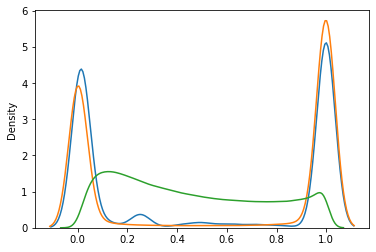

In [101]:
sns.kdeplot(clf_geodesic_69336.predict_proba(X_test_geodesic)[:, 1])
sns.kdeplot(clf_embeddings_69336_mlp.predict_proba(X_test_embeddings)[:, 1])
sns.kdeplot(clf_embeddings_69336_lr.predict_proba(X_test_embeddings_hadamard)[:, 1])

In [99]:
clf_embeddings_69336_lr.score(X_test_embeddings_hadamard, y_test)

0.7449782260187112

get top-ranked novel edges

In [126]:
X_test_indices = np.load("X_test_indices.npy").tolist()
test_probs = clf_geodesic_69336.predict_proba(X_test_geodesic)[:, 1]

In [160]:
def get_topk_novel(predict_proba, targets, X_test_indices, all_vertices, k):
    """
    """
    novel_probs = np.multiply(predict_proba, np.abs(np.array(targets)-1))
    top_indices = (-novel_probs).argsort()[:k].tolist()
    return [
        (all_vertices[X_test_indices[i][0]], all_vertices[X_test_indices[i][1]]) \
        for i in top_indices
    ], novel_probs[top_indices]

In [224]:
edges, probs = get_topk_novel(test_probs, y_test, X_test_indices, all_vertices, 1000)

In [225]:
data = [
    (edges[i][0]+" <-> "+edges[i][1], probs[i]) \
    for i in range(len(edges))
]

In [226]:
from tabulate import tabulate

In [227]:
header = ["Edge", "Estimated Link Probability"]

In [228]:
table = tabulate(data, headers = header, tablefmt = "grid", numalign = "center")

In [229]:
print(table)

+-----------------------+------------------------------+
| Edge                  |  Estimated Link Probability  |
+=======================+==============================+
| C0035236 <-> C1441604 |           0.999488           |
+-----------------------+------------------------------+
| C0027362 <-> C0020967 |           0.999487           |
+-----------------------+------------------------------+
| C0003062 <-> C0012754 |           0.999484           |
+-----------------------+------------------------------+
| C0086418 <-> C0027934 |           0.999484           |
+-----------------------+------------------------------+
| C0006104 <-> C0333230 |           0.999484           |
+-----------------------+------------------------------+
| C1314650 <-> C2700280 |           0.999464           |
+-----------------------+------------------------------+
| C0543467 <-> C0265883 |           0.99945            |
+-----------------------+------------------------------+
| C0582175 <-> C2697883 |      

In [230]:
with open('novel_relations.txt', 'w') as f:
    f.write(table)